In [1]:
import tensorflow as tf
from tqdm import tqdm
import numpy as np
from transformers import RobertaTokenizer, RobertaConfig, TFRobertaModel
from sklearn.model_selection import train_test_split
import pickle
import random
import sys
import math
from scipy import stats
from scipy.spatial import distance
import random
import os
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

C:\ProgramData\anaconda3\envs\research\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [3]:
base_folder = "../../datasets/"
input_file = "hate_int_prof_SVO.tsv"

output_folder = "output_weights/"
output_file = "output_weights"

roberta_model = "roberta-base"
max_length = 256
TEST_SIZE = 0.2
seed = 42

use_attention = True

roberta_dropout = 0.2
lstm_units = 256
dense_units = 50
lstm_dropout = 0.1
dense_dropout = 0.2
epochs = 30 #(Default 10)
batch_size = 32

def random_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

random_seed(seed)

In [4]:
dataframe = pd.read_table(base_folder + input_file)
dataframe.head()

,Sentence,Intensity,Profanity,Subject,Verb,Object
0,Islam looks like a cult more than like a relig...,9.0,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,We must send Islamics back to their native cou...,7.0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"Europe is civilised, Muslims should not stay t...",7.0,0,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,"If they love Sharia law so much, why do not th...",8.0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Islam=evil. Islam is invading us and trying to...,7.0,0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."


In [5]:
## Define base Roberta configs
# config = RobertaConfig(dropout=roberta_dropout, attention_dropout=roberta_dropout, output_attentions=True)
config = RobertaConfig.from_pretrained(roberta_model, output_hidden_states=False, attention_probs_dropout_prob=roberta_dropout, output_attentions = True)
config.output_hidden_states = False

transformer_model = TFRobertaModel.from_pretrained(roberta_model, config=config, ignore_mismatched_sizes=True)
for layer in transformer_model.layers[:3]:  ## Freeze first 3 layers
    layer.trainable = False

# Defining tokonizer
tokenizer = RobertaTokenizer.from_pretrained(roberta_model, do_lower_case=True, add_special_tokens=True, max_length=max_length, pad_to_max_length=True)

C:\ProgramData\anaconda3\envs\research\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification mo

In [6]:
input_ids_in = tf.keras.layers.Input(shape=(max_length, ), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length, ), name='masked_token', dtype='int32')

input_ids_in

<KerasTensor: shape=(None, 256) dtype=int32 (created by layer 'input_token')>

In [7]:
input_ids_in = tf.keras.layers.Input(shape=(max_length, ), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length, ), name='masked_token', dtype='int32')

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]

X = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(lstm_units, return_sequences=True, dropout=lstm_dropout, 
                             recurrent_dropout=lstm_dropout, kernel_initializer='normal')
    )(embedding_layer)

if use_attention:
    X = tf.keras.layers.Attention(use_scale=True)([X, X])  # Use attention.
    
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(dense_units, activation='relu',  kernel_initializer='normal')(X)
X = tf.keras.layers.Dropout(dense_dropout)(X)
X = tf.keras.layers.Dense(1, activation='linear', kernel_initializer='normal')(X)

model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs=X)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc', tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 256)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_token[0][0]',            
 el)                            thPoolingAndCrossAt               'masked_token[0][0]']           
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [10]:
for layer in model.layers:
    for weight in layer.weights:
        print(f"{weight.name}: {weight.shape}")

tf_roberta_model/roberta/encoder/layer_._0/attention/self/query/kernel:0: (768, 768)
tf_roberta_model/roberta/encoder/layer_._0/attention/self/query/bias:0: (768,)
tf_roberta_model/roberta/encoder/layer_._0/attention/self/key/kernel:0: (768, 768)
tf_roberta_model/roberta/encoder/layer_._0/attention/self/key/bias:0: (768,)
tf_roberta_model/roberta/encoder/layer_._0/attention/self/value/kernel:0: (768, 768)
tf_roberta_model/roberta/encoder/layer_._0/attention/self/value/bias:0: (768,)
tf_roberta_model/roberta/encoder/layer_._0/attention/output/dense/kernel:0: (768, 768)
tf_roberta_model/roberta/encoder/layer_._0/attention/output/dense/bias:0: (768,)
tf_roberta_model/roberta/encoder/layer_._0/attention/output/LayerNorm/gamma:0: (768,)
tf_roberta_model/roberta/encoder/layer_._0/attention/output/LayerNorm/beta:0: (768,)
tf_roberta_model/roberta/encoder/layer_._0/intermediate/dense/kernel:0: (768, 3072)
tf_roberta_model/roberta/encoder/layer_._0/intermediate/dense/bias:0: (3072,)
tf_roberta_

In [7]:
def tokenize(sentences, subject_embeddings, verb_embeddings, object_embeddings, svo_embeddings, tokenizer, sentence_length):
    input_ids, input_masks, input_segments = [], [], []
    
    for sentence, subj_emb, verb_emb, obj_emb, svo_emb in tqdm(zip(sentences, subject_embeddings, verb_embeddings, object_embeddings, svo_embeddings)):
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=sentence_length,
                                       pad_to_max_length=True, return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])

        input_ids[-1].extend(svo_emb.tolist())
        input_masks[-1].extend([1] * len(svo_emb))
        input_segments[-1].extend([1] * len(svo_emb))
    
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')

input_data = pd.read_table(base_folder + input_file)

sentences = input_data['Sentence'].tolist()
intensity_value = input_data['Intensity'].astype(int).tolist()

SVO_length = 128
subject_embeddings = (pad_sequences([np.fromstring(embedding[1:-1], dtype=int, sep=',') for embedding in input_data["Subject"].tolist()], maxlen=SVO_length, padding='post'))
verb_embeddings = (pad_sequences([np.fromstring(embedding[1:-1], dtype=int, sep=',') for embedding in input_data["Verb"].tolist()], maxlen=SVO_length, padding='post'))
object_embeddings = (pad_sequences([np.fromstring(embedding[1:-1], dtype=int, sep=',') for embedding in input_data["Object"].tolist()], maxlen=SVO_length, padding='post'))

# adding all the embeddings together to truncate them when putting them in a model (instead of 128 * 3, it will be 128)
svo_embeddings = subject_embeddings + verb_embeddings + object_embeddings

c = list(zip(intensity_value, sentences, subject_embeddings, verb_embeddings, object_embeddings, svo_embeddings))
random.shuffle(c)
intensity_value, sentences, subject_embeddings, verb_embeddings, object_embeddings, svo_embeddings = zip(*c)

X_tr, X_te, y_tr, y_te = train_test_split(sentences, intensity_value, test_size=TEST_SIZE, random_state=1)

sentence_length = 128
train_input_ids, train_input_masks, train_input_segment = tokenize(X_tr, subject_embeddings, verb_embeddings, object_embeddings, svo_embeddings, tokenizer, sentence_length)
test_input_ids, test_input_masks, test_input_segment = tokenize(X_te, subject_embeddings, verb_embeddings, object_embeddings, svo_embeddings, tokenizer, sentence_length)

y_tr = np.asarray(y_tr)
y_te = np.asarray(y_te)


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\ProgramData\anaconda3\envs\research\lib\site-packages\transformers\tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
4843it [00:01, 3999.17it/s]
1211it [00:00, 5045.87it/s]


In [8]:
# print(X_tr) # Training sentences
print("Train input ids: \n", len(train_input_ids[100]), 
      "\n\nAttention masks: \n", len(train_input_masks[0]),  
      "\n\nToken type ids: \n", len(train_input_segment[0])) # input_ids, attention_masks, token_type_ids

Train input ids: 
 256 

Attention masks: 
 256 

Token type ids: 
 256


### LSTM Units = 128
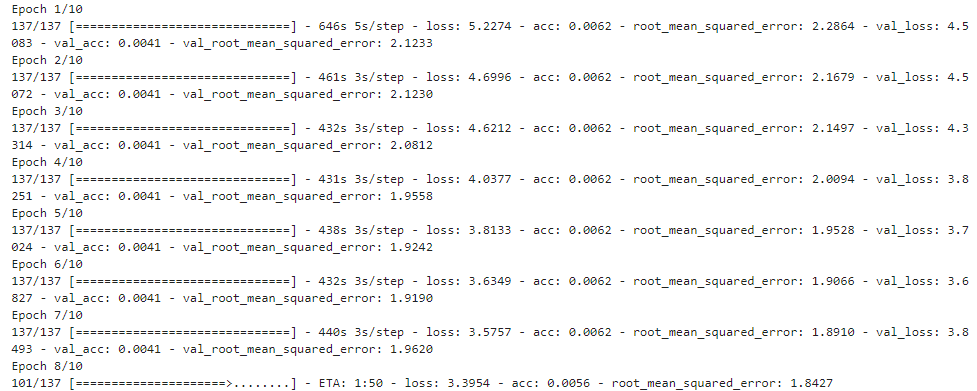

### LSTM Units = 256
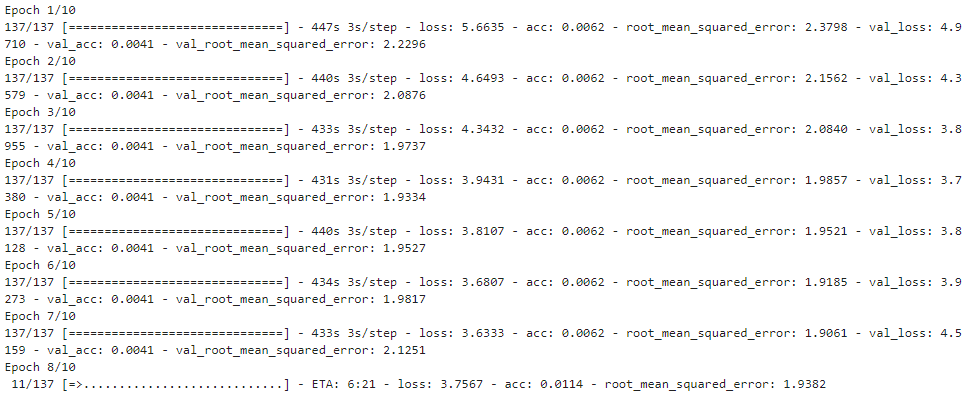

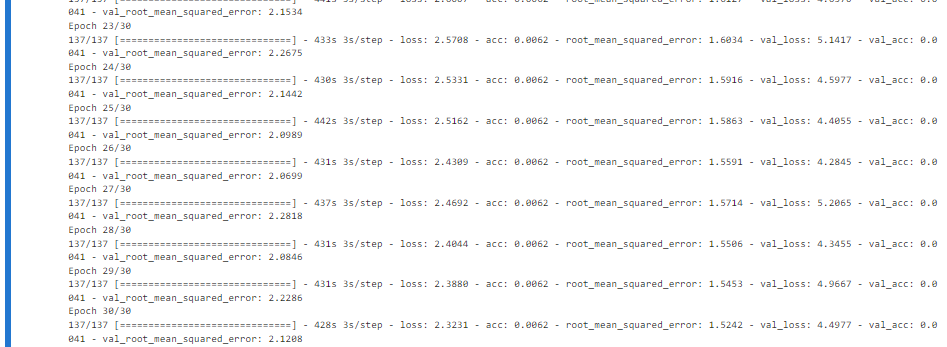

### LSTM Units = 128
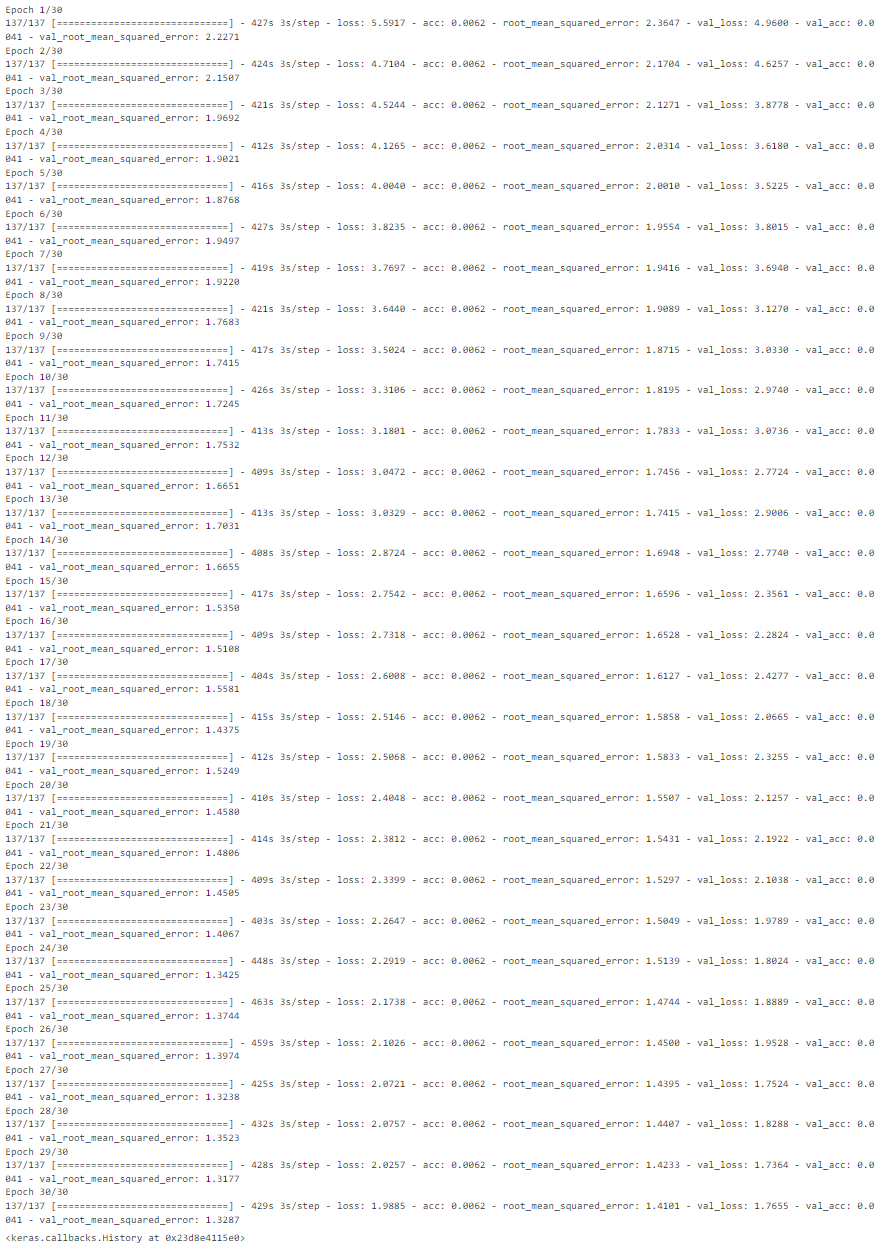

In [9]:
model.fit(x=[train_input_ids, train_input_masks], y=y_tr, epochs=epochs, validation_split=0.1, batch_size=batch_size)

Epoch 1/30
137/137 [==============================] - 427s 3s/step - loss: 5.5917 - acc: 0.0062 - root_mean_squared_error: 2.3647 - val_loss: 4.9600 - val_acc: 0.0041 - val_root_mean_squared_error: 2.2271
Epoch 2/30
137/137 [==============================] - 424s 3s/step - loss: 4.7104 - acc: 0.0062 - root_mean_squared_error: 2.1704 - val_loss: 4.6257 - val_acc: 0.0041 - val_root_mean_squared_error: 2.1507
Epoch 3/30
137/137 [==============================] - 421s 3s/step - loss: 4.5244 - acc: 0.0062 - root_mean_squared_error: 2.1271 - val_loss: 3.8778 - val_acc: 0.0041 - val_root_mean_squared_error: 1.9692
Epoch 4/30
137/137 [==============================] - 412s 3s/step - loss: 4.1265 - acc: 0.0062 - root_mean_squared_error: 2.0314 - val_loss: 3.6180 - val_acc: 0.0041 - val_root_mean_squared_error: 1.9021
Epoch 5/30
137/137 [==============================] - 416s 3s/step - loss: 4.0040 - acc: 0.0062 - root_mean_squared_error: 2.0010 - val_loss: 3.5225 - val_acc: 0.0041 - val_root_me

In [10]:
results = model.evaluate(x=[test_input_ids, test_input_masks], y=y_te)
print(results)

result = model.predict(x=[test_input_ids, test_input_masks])
result = np.array(result, dtype=np.float64)
result = result.flatten()

38/38 [==============================] - 31s 805ms/step - loss: 4.2812 - acc: 0.0083 - root_mean_squared_error: 2.0691
[4.2812042236328125, 0.008257638663053513, 2.0691070556640625]
38/38 [==============================] - 34s 801ms/step


In [11]:
_, _, rmse = results
print("RMSE", rmse)
print("Pearson", stats.pearsonr(result, y_te))
print("Cosine", 1 - distance.cosine(result, y_te))

RMSE 2.0691070556640625
Pearson PearsonRResult(statistic=0.35425755286069494, pvalue=4.009937125442718e-37)
Cosine 0.9358549503338093
